<a href="https://colab.research.google.com/github/MattKimmmm/hw2/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignement 2 Language Models and Intoduction to Hugging Face

Notes
Introduction
Welcome to CSE 527A. Each assignment will contain two parts: a written and coding portion. The coding portion for each homework assignment will be delivered through a Colaboratory notebook such as this one. Please use as many code and markdown cells to run and explain all the steps you took in order to answer each question for each problem. Please keep in mind the collaboration policy as specified in the Academic Integrity section of the syllabus and cite all external sources and/or collaborators.

Comments/Documentation
Please follow PEP 8 style guidelines (https://peps.python.org/pep-0008/) for commenting your code. Furthermore, please remember to manually save your work once in a while. If you are connected to a hosted runtime that if for whatever reason it disconnects you will have to rerun all connected code cells.

Getting Started
In order to compile code efficiently, enable GPU support.

To access a GPU, go to Edit->Notebook settings and in the Hardware accelerator dropdown choose GPU. As soon as you run a code cell, you will be connected to a cloud instance with a GPU. Try running the code cell below to check that a GPU is connected (select the cell then either click the play button at the top left or press Ctrl+Enter or Shift+Enter).

The free version of Google Colab will provide the necessary hardware for this course. Please keep in mind the RAM and Disk Space that you are allocated and that you are not given an infinite active runtime.

Submission Instructions
We will use Gradescope for assignment submission. Submit the written and code portions of the assignment to the respective assignments. Please note if notebook output is cleared, you will receive a 0. To download this notebook, go to File->Download .ipynb.

When submitting your ipython notebooks, make sure everything runs correctly if the cells are executed in order starting from a fresh session. Note that just because a cell runs in your current session doesn't mean it doesn't rely on code that you have already changed or deleted.

Note that Gradesope will allow you to submit multiple times before the deadline, and we will use the latest submission for grading.

## **Setup**

In [ ]:
from google.colab import drive # one option to load datasets
from google.colab import files
drive.mount('/content/gdrive')
!nvidia-smi -L # check if using GPU

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-456b51d6-2825-7818-2552-e7766a38e292)


In [ ]:
# various imports you might find useful, feel free to import additional packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

In [ ]:
! pip install datasets --use-deprecated=legacy-resolver

In [ ]:
from datasets import load_dataset

# Load the dataset
trainset = load_dataset("wikitext", name="wikitext-2-v1", split="train")
valset = load_dataset("wikitext", name="wikitext-2-v1", split="validation")
testset = load_dataset("wikitext", name="wikitext-2-v1", split="test")

# Preprocess text
punctuation = list("~!@#$%^&*()_+`{}|\[\]\:\";\-\\\='<>?,./，。、《》？；：‘“{【】}|、！@#￥%……&*（）——+=-")
def preprocess(dataset):
  data = []
  for text in dataset['text']:
    # Ignore emtpy sentences
    if text == '':
      continue
    # Remove puncutation and unknown tokens
    tokens = [t for t in text.split() if t != '' and t not in punctuation and t != '<unk>']
    data.append(tokens)
  return data
traindata = preprocess(trainset)
valdata = preprocess(valset)
testdata = preprocess(testset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Problem 1
(Eisenstein Ch. 6) Using the Pytorch library, train an LSTM language model from the same Wikitext training corpus you used in problem 1. After each epoch of training, compute its perplexity on the Wikitext validation corpus. Stop training when the perplexity stops improving.

1. Fully describe your model architecture, hyperparameters, and experimental procedure.
2. After each epoch of training, compute your LM’s perplexity on the development data. Plot the development perplexity against # of epochs. Additionally, compute and report the perplexity on test
data.

**NOTE:** This may take some time, so you should start early. Also, you should use a GPU. When using PyTorch, you can move your model and data to the GPU with the following commands:

```
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # This is defined for you
model.to(device)
x = x.to(device)
```

**The PyTorch documentation is very good; I recommend reading it.**
Start here: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

Good luck, and post on Piazza if you have any questions or see any errors.

### Starting Point
First, find the distribution of sentence length to decide the max-length for training RNN models.

In [ ]:
# Your code goes here
import pandas as pd

def get_lengths(data):
  return [len(sentence) for sentence in data]

def analyze_length(data, dataset_name):
  lengths = get_lengths(data)
  plt.figure()
  plt.hist(lengths, bins=30, label=dataset_name)
  plt.xlabel('Sentence Length')
  plt.ylabel('Frequency')
  plt.title(dataset_name)
  plt.show()

  series = pd.Series(lengths)
  print(f"{dataset_name} Descriptive Statistics:\n{series.describe()}")
  print(f"{dataset_name} Percentiles:\n{series.quantile([0.9, 0.95, 0.99])}")

analyze_length(traindata, "Train")
analyze_length(testdata, "Test")
analyze_length(valdata, "Validation")




Based on the above, choose the max-length for training RNN models.

**TODO**: select these values based on the above.

In [ ]:
# TODO: select these values based on the above.
MAXLEN = 200 # Maximum length of the input sentences
batch_size = 64 # For training

Now, run the below to load the data.

*Note: This is done for you; there is no code to write here*.

Creating the Model

Next, create an LSTM with PyTorch.

In [ ]:
# Covert list of tokens to list of token ids
def indexData(data, word2index=None):
    """
    data: corpus - list of list of tokens
    word2index: None before training
    """
    if word2index is None:
        freqs = {}
        for in_list in data:
            for w in in_list:
              freqs[w] = freqs.get(w, 0) + 1
        vocab = [w for w, c in freqs.items() if c > 5] # Ignore words of low frequency
        word2index = {word: index + 1 for index, word in enumerate(vocab)}
        word2index['<pad>'] = 0
    data_ids = []
    for seq in data:
      data_ids.append([word2index[w] if w in word2index else 0 for w in seq[:MAXLEN]]) # Use maxlen to define the max length of input
    return data_ids, word2index


# Convert list of token ids to padding sequences
def genSeq(data_id):
    inputs = [torch.LongTensor(seq) for seq in data_id]
    inputs_padded = pad_sequence(sequences=inputs, batch_first=True, padding_value=0)
    return inputs_padded

# Get dataloader for pytorch models
def gendataloader(data_id, batch_size, shuffle=False):
    inputs_padded = genSeq(data_id)
    print(inputs_padded.shape)
    t_dataset = TensorDataset(inputs_padded)
    return DataLoader(dataset=t_dataset, batch_size=batch_size, shuffle=shuffle)

traindata_id, word2index = indexData(traindata, word2index=None)
valdata_id, word2index = indexData(valdata, word2index=word2index)
testdata_id, word2index = indexData(testdata, word2index=word2index)

train_loader = gendataloader(traindata_id, batch_size, shuffle=True)
val_loader = gendataloader(valdata_id, batch_size, shuffle=False)
test_loader = gendataloader(testdata_id, batch_size, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use 'cpu' if a GPU is not available.

# Show vocabulary size
vocab_size = len(word2index)
vocab_size
for i,x in enumerate(train_loader):
  x = x[0]
  x = x[:-1]
  print (x)

In [ ]:
class lmLSTM(nn.Module):
    def __init__(self,  vocab_size, embed_dim, hidden_dim, num_layers=1):
        """
        Args:
            vocab_size: size of the vocabulary.
            embed_dim: size of the word embedding.
            hidden_dim: size of the hidden state of the LSTM.
            num_layers: number of layers in the LSTM.

        """
        super(lmLSTM, self).__init__()
        # Your code goes here
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embed = nn.Embedding(vocab_size, embed_dim)

        # initialize parameters
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)

        # a linear layer to map outputs[hidden_dim] to vocab size[vocab_size]
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def init_state(self, batch_size):
        """ Initialize states of LSTM

        This is the first step of the forward pass. The LSTM has two states,
        the hidden state and the cell state. These are initialized here and
        put to the right device.

        Args:
            batch_size: size of the batch.

        Returns:
            initialized states.

        """
        # Your code goes here
        hidden_state = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        cell_state = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        return (hidden_state, cell_state)

    def detach_states(self, states):
        """Detach states of LSTM

        This is the last step of the forward pass. The LSTM has two states,
        the hidden state and the cell state. These are detached because the
        LSTM is trained using truncated backpropagation through time.

        Args:
            states: the LSTM states to detach.

        Returns:
            detached states.

        """
        # Your code goes here
        return (states[0].detach(), states[1].detach())

    def forward(self, inputs, states):
        """Defines the computation performed at every call.

        Args:
            inputs: batch of input sentences.
            states: the LSTM states.

        Returns:
            logits: the output logits.
            states: the updated states of the LSTM.

        """
        # Your code goes here
        embedded = self.embed(inputs)
        logits, states = self.lstm(embedded, states)
        logits = self.linear(logits)
        logits_flatten = logits.reshape(-1, vocab_size)
        # print(f"At forward logit shape: {logits.shape}")

        return logits_flatten, states

After creating the model, let's define reasonable hyperparameters as well as the training procedure.

Embedding Dimension = 200: A dimension of 200, close to the 95% percentile for each dataset, balances between the model complexity and the ability to capture enough information.

Hidden Dimension = 256: This value is set to not overcomplicate the model with higher dimensions, and yet to still capture the sequence dynamics

Number of Layers = 10: I intended to include additional hidden layers besides the embedding layer without overcomplicating the model

Number of Epochs: 100 is a good starting point to see how the training works given other parameters. I intentionally set it low since I would not have to worry about overfit and I can always increase the epoch numbers if the training loop needs more iteration.

Learning Rate = 0.0001: A standard starting point, it exhibits a good balance between ensuring the progress and avoiding overfitting.


Training Overview:
At each iteration, a new state is initialized. Data is loaded from dataloader and X and y will be processed as needed. This preprocessing includes creating y label that is 1 index shifted from X, since our purpose is to predict the next word of the sequence.\
Then the input is fed into the model, and the resulting logit is compared to the labels and evaluated by the loss function. Once states are calculated and utilzied, they are detached before the new iteration. For each epoch, batch losses are aggregated and the sequence complexity is calculated. Based on the loss and constraints, the new epoch is run or the program stops.

**TODO**: select these values based on the above.

In [ ]:
# TODO: update Hyperparameters
embed_dim = 200 # Embedding layer size
hidden_dim = 256 # (LSTM) hidden layer size
num_layers= 10 # Number of LSTM layers
num_epoch = 100 # The maximum training epochs
learning_rate = 0.0001 # For training

Initialize the model and any other variables you need. (Change the values from ```None``` to your code)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use 'cpu' if a GPU is not available.

# Initialization of the model
model = lmLSTM(vocab_size, embed_dim, hidden_dim, num_layers = num_layers)

# Move model to the right device, initialize optimizer and loss
model.to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



Let's define perplexity to use in our analysis.

In [ ]:
# Compute perplexity based on losses
def perplexity(data, model):
    """Compute perplexity of the data.

    Args:
        data: the data to compute the perplexity of.
        model: the language model.

    Returns:
        perplexity of the data (float)

    """
    with torch.no_grad():
        # Your code goes here
        losses = []
        for i, x in enumerate(data):
          x = x[0] # 64 * 200 (Batch * len)
          y = torch.roll(x, -1)
          states = model.init_state(x.size()[0] - 1)
          x = x[:-1]
          y = y[:-1]
          x = x.to(device)
          y = y.to(device)
          states = model.detach_states(states)
          logits, states = model(x,states)
          # print(f"logits: {logits.shape}")
          # print(f"y: {y.shape}")
          l = loss(logits, y.reshape(-1))
          losses.append(l.item() / (x.size()[0] - 1))
    perplexity = np.exp(np.mean(losses))
    return perplexity



Training the Model
Now set up the training loop.  **TODO**: steps 2 and 3 in the training code below

In [ ]:
# Train
val_pps = [] # List of perplexities on the validation data

def training(model, num_epoch, learning_rate, loss, optimizer):
  """Training of the model. Describe what happens in the training loop.

  The model is trained using backpropagation through time. The
  states of the LSTM are detached at the end of each epoch.

  There are three main steps in the training loop:
  1. Get the data and run the model
  2. Update the parameters
  3. Save the loss and compute the perplexity on the validation data;
    if the perplexity is higher than the previous epoch, return the model.

    You will do steps 2 and 3

    Make sure to put the model in train mode at the beginning of each epoch and
    put the model in eval mode at the beginning of each evaluation step.

  Returns:
      the trained model.

  """
  count = 0
  for epoch in range(num_epoch):
    states = model.init_state(batch_size - 1)
    losses = []
    for i, X in enumerate(train_loader):
      # Reset gradients
      optimizer.zero_grad()
      model.train()

      # Prepare
      X = X[0] # 128 * 200
      # print(f"X: {X.shape}")
      if X.size()[0] != batch_size:
        continue
      y = torch.roll(X,-1) # Derive the labels (shift x)
      # print(f"y: {y.shape}")
      X = X[:-1] # Remove last step for X
      y = y[:-1] # Remove last step for y
      #print("After removing last step for X and y")
      #print(f"X: {X.shape}, y: {y.shape}\n")
      X = X.to(device)
      y = y.to(device)

      # Run model
      # Your code goes here
      output, states = model(X, states)
      states = model.detach_states(states)

      # loss
      # print(f"Output: {output.shape}")
      # print(f"y: {y.shape}")
      #print(y)
      y_flatten = y.reshape(-1)
      loss_val = loss(output, y_flatten)
      losses.append(loss_val.item())

      # Backpropagation
      loss_val.backward()

      # Update the parameters
      # Your code goes here
      optimizer.step()


    model.eval()
    val_perplexity = perplexity(val_loader, model) # Compute validation perplexity
    print(epoch, 'train loss: ', np.mean(losses), '| validation perplexity: ', val_perplexity)
    val_pps.append(val_perplexity)
    # try to change the constraints (its not changed to -2 from -1)
    if epoch > 1 and val_perplexity > val_pps[-2]:
      count += 1

    if epoch > 1 and count >= 5:
        return model

In [ ]:
# model = training(model, num_epoch, learning_rate, loss, optimizer)

Now run the training! This part is done for you, but may take time to run, so be patient.

In [ ]:
s = time.time()
model = training(model, num_epoch, learning_rate, loss, optimizer)
lstm_time = time.time() - s # Record time
print(f"Training took {lstm_time} seconds")
test_perplexity = perplexity(test_loader, model)

0 train loss:  3.163111750970311 | validation perplexity:  1.0547085136501217
1 train loss:  3.1587381934862573 | validation perplexity:  1.054685878469178
2 train loss:  3.159593596933987 | validation perplexity:  1.0546740096260236
3 train loss:  3.16185537245717 | validation perplexity:  1.0546266831458515
4 train loss:  2.795087243990114 | validation perplexity:  1.0450412228706878
5 train loss:  2.5787266055850004 | validation perplexity:  1.0442264459039794
6 train loss:  2.5398688634450868 | validation perplexity:  1.04362954209967
7 train loss:  2.512341864025496 | validation perplexity:  1.0431956917982637
8 train loss:  2.494302515392355 | validation perplexity:  1.04288056428375
9 train loss:  2.4747996481281085 | validation perplexity:  1.042628586944195
10 train loss:  2.4595742444143784 | validation perplexity:  1.0424168548029336
11 train loss:  2.4490718436690995 | validation perplexity:  1.042233361711835
12 train loss:  2.440933981031742 | validation perplexity:  1.04

### Evaluating the Model
Now, plot the perplexity on the eval data against the number of epochs.

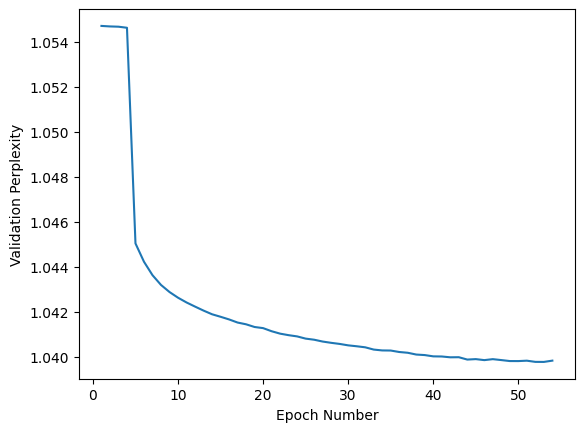

In [ ]:
# Your code goes here
val_pps = [
    1.0547085136501217, 1.054685878469178, 1.0546740096260236, 1.0546266831458515,
    1.0450412228706878, 1.0442264459039794, 1.04362954209967, 1.0431956917982637,
    1.04288056428375, 1.042628586944195, 1.0424168548029336, 1.042233361711835,
    1.042055574900576, 1.0418922770145322, 1.0417809070607986, 1.0416629463082168,
    1.0415243562002774, 1.0414461349504185, 1.0413264256203962, 1.0412764335171116,
    1.041138538669381, 1.041030906356901, 1.0409628299508233, 1.040908461397213,
    1.04080988339424, 1.040761008413326, 1.0406796572063999, 1.0406228484314284,
    1.0405739239591556, 1.0405106493545526, 1.0404701030425056, 1.04042369425363,
    1.04032326104763, 1.0402848260179838, 1.040280000473696, 1.0402152977590027,
    1.0401810907447033, 1.0401020409910158, 1.0400785616557078, 1.0400214280220488,
    1.0400155864768086, 1.0399794384916037, 1.039983521947105, 1.0398787731405617,
    1.0398987332431084, 1.0398540801943903, 1.0398971444469796, 1.039856139344563,
    1.0398127638885195, 1.0398114752842562, 1.0398293563544376, 1.0397762666796049,
    1.0397741414518127, 1.0398313627709348
]
epoch_num = [i + 1 for i, j in enumerate(val_pps)]
# print(epoch_num)

# plot val_pps v epoch number
plt.figure()
plt.plot(epoch_num, val_pps)
plt.xlabel('Epoch Number')
plt.ylabel('Validation Perplexity')
plt.show()


Finally, describe your model architecture, hyperparameters, and experimental procedure. Then, discuss the results you obtained.

Model Architecture and Hyperparameters\
The model is based on LSTM, which is a type of RNN with the addition of "gates." meant for filtering information between LSTM cells.\
Embedding Layer: The first layer has  dimension of 200, equivanlent to the input sequence.\
Hidden Layer: 9 other layers beside the embedding layer has dimension of 256, which was assumed to be a good starting point for various tasks. From the test results, this choice was indeed correct and worked well. Number of hidden layer was determined based on the need for capturing long-term dependencies of the word sequence, while not over-complicating the model.\
Linear Layer: The output of the LSTM layers is passed through a dense layer, which projects the LSTM output to the vocabulary size.\
Number of Epochs and Learning Rate: These two hyperparameters were set to balance between overfitting and underfitting. Then they were adjusted to make enough observation of the trend of decreasing validation perplexity, since the model was converging too fast initially.

Experimental Procedure\
The training involves iteratively updating the model's weights to minimize the loss function, which is the cross entropy loss. The performance was measured based on the validation perplexity.

Result Discussion\
The reported validation perplexity values show a gradual decrease over the epochs, starting from 1.0547 and decreasing to 1.0398. After a significant drop at the early epochs, the rate of improvement slows down as the training progresses. The achieved perplexity of 1.0398 is remarkable, where in practical terms, a perplexity close to 1 suggests that the model predicts the next word in the sequence with a high certainty and minimal confusion. However, such a low value might suggest overfitting.

## Problem 2 Hugging Face
In this part of the homework you will load a small LLM and fine-tune it to answer questions of the SQuAD dataset.

In [ ]:
! pip install datasets transformers accelerate -U


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.1
    Uninstalling transformers-4.38.1:
      Successfully uninstalled transformers-4.38.1


The first step is load in the SQuAD dataset.  Take a look at its description here: https://huggingface.co/datasets/squad

**TODO** Write a short description of SQuAD

Standford Question Answering Dataset (SQuAD) is a reading comprehension dataset, consisting of quetions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable. Each data point is consisted of title, context, question, and answer.

In [ ]:
from datasets import load_dataset,load_metric

datasets = load_dataset("squad_v2")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

**TODO**:  Display the first element of the training part of the dataset

In [ ]:
# your code here
print(datasets['train'][0])

{'id': '56be85543aeaaa14008c9063', 'title': 'Beyoncé', 'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".', 'question': 'When did Beyonce start becoming popular?', 'answers': {'text': ['in the late 1990s'], 'answer_start': [269]}}


### Preprocessing
In this section we will be doing Pre-Processing.

We will be using distilbert which is a smaller version of the BERT.  You can read more here: https://arxiv.org/abs/1910.01108

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

**TODO** Use the tokenizer and tokenize the first question-context pair and then print it.

In [ ]:
# your code here
question = datasets['train'][0]["question"]
question_tokenized = tokenizer.encode(question)
print(question_tokenized)

context = datasets['train'][0]["context"]
context_tokenized = tokenizer.encode(context)
print(context_tokenized)

[101, 2043, 2106, 20773, 2707, 3352, 2759, 1029, 102]
[101, 20773, 21025, 19358, 22815, 1011, 5708, 1006, 1013, 12170, 23432, 29715, 3501, 29678, 12325, 29685, 1013, 10506, 1011, 10930, 2078, 1011, 2360, 1007, 1006, 2141, 2244, 1018, 1010, 3261, 1007, 2003, 2019, 2137, 3220, 1010, 6009, 1010, 2501, 3135, 1998, 3883, 1012, 2141, 1998, 2992, 1999, 5395, 1010, 3146, 1010, 2016, 2864, 1999, 2536, 4823, 1998, 5613, 6479, 2004, 1037, 2775, 1010, 1998, 3123, 2000, 4476, 1999, 1996, 2397, 4134, 2004, 2599, 3220, 1997, 1054, 1004, 1038, 2611, 1011, 2177, 10461, 1005, 1055, 2775, 1012, 3266, 2011, 2014, 2269, 1010, 25436, 22815, 1010, 1996, 2177, 2150, 2028, 1997, 1996, 2088, 1005, 1055, 2190, 1011, 4855, 2611, 2967, 1997, 2035, 2051, 1012, 2037, 14221, 2387, 1996, 2713, 1997, 20773, 1005, 1055, 2834, 2201, 1010, 20754, 1999, 2293, 1006, 2494, 1007, 1010, 2029, 2511, 2014, 2004, 1037, 3948, 3063, 4969, 1010, 3687, 2274, 8922, 2982, 1998, 2956, 1996, 4908, 2980, 2531, 2193, 1011, 2028, 3895, 1000

**TODO**: As you did in the first problem find the distibution of the tokenized length of the question and its context

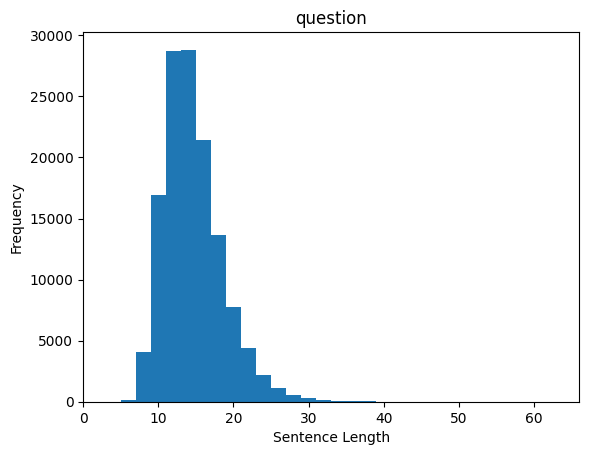

question Descriptive Statistics:
count    130319.000000
mean         14.132966
std           3.939998
min           3.000000
25%          11.000000
50%          14.000000
75%          16.000000
max          63.000000
dtype: float64
question Percentiles:
0.90    19.0
0.95    21.0
0.99    26.0
dtype: float64


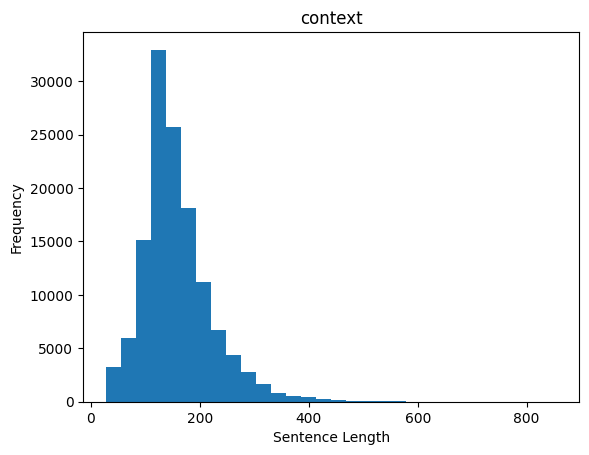

context Descriptive Statistics:
count    130319.000000
mean        157.593666
std          65.211297
min          27.000000
25%         116.000000
50%         145.000000
75%         187.000000
max         855.000000
dtype: float64
context Percentiles:
0.90    240.0
0.95    279.0
0.99    376.0
dtype: float64


In [ ]:
# your code here
def analyze_length(lengths, dataset_name):
  plt.figure()
  plt.hist(lengths, bins=30, label=dataset_name)
  plt.xlabel('Sentence Length')
  plt.ylabel('Frequency')
  plt.title(dataset_name)
  plt.show()

  series = pd.Series(lengths)
  print(f"{dataset_name} Descriptive Statistics:\n{series.describe()}")
  print(f"{dataset_name} Percentiles:\n{series.quantile([0.9, 0.95, 0.99])}")

dataset_train = datasets['train']
question_lengths = []
context_lengths = []

for d in dataset_train:
    question_lengths.append(len(tokenizer.encode(d["question"])))
    context_lengths.append(len(tokenizer.encode(d["context"])))

analyze_length(question_lengths, "question")
analyze_length(context_lengths, "context")


As you can see there are many long documents in the dataset.  Truncation is not possible in this case because then we lose some information.  We will break up the context into multiple data features.

**TODO**: Set max length

In [ ]:
# 99% percentiles for both question and contest = 26 + 376 = 400
max_length = 400 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

Now let's look at a large example in the dataset.

In [ ]:
for i, example in enumerate(datasets["train"]):
    if len(tokenizer(example["question"], example["context"])["input_ids"]) > max_length:
        break
example = datasets["train"][i]

In [ ]:
len(tokenizer(example["question"], example["context"])["input_ids"])

437

We will have to seperate this!  But we need to know if the answer to the question is in the chuck of context we give it.


The code below will properly seperate the example.

 **TODO**: Fill in the arguments for the tokenizer.

In [ ]:
#TODO fill in the arguments for the tokenizer
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)
print(tokenized_example["offset_mapping"][0][:100])
print(tokenized_example["input_ids"])

[(0, 0), (0, 7), (8, 11), (12, 19), (20, 22), (23, 27), (28, 30), (31, 35), (35, 36), (0, 0), (0, 2), (3, 8), (9, 10), (10, 11), (12, 16), (16, 17), (18, 25), (26, 33), (34, 37), (38, 39), (39, 40), (41, 44), (45, 53), (54, 62), (63, 68), (69, 77), (78, 80), (81, 82), (83, 88), (89, 93), (93, 96), (97, 99), (100, 103), (104, 113), (114, 119), (120, 123), (124, 127), (128, 133), (134, 140), (141, 146), (146, 147), (148, 149), (150, 152), (152, 153), (153, 154), (154, 155), (156, 161), (162, 168), (168, 169), (170, 172), (173, 182), (182, 183), (183, 184), (185, 189), (190, 194), (195, 197), (198, 205), (206, 208), (208, 209), (210, 214), (214, 215), (216, 217), (218, 220), (220, 221), (221, 222), (222, 223), (224, 229), (230, 236), (237, 240), (241, 249), (250, 252), (253, 261), (262, 264), (264, 265), (266, 270), (271, 273), (274, 277), (278, 284), (285, 291), (291, 292), (293, 296), (297, 302), (303, 311), (312, 322), (323, 330), (330, 331), (331, 332), (333, 338), (339, 342), (343, 3

This gives, for each index of our input IDS, the corresponding start and end character in the original text that gave our token.

In [ ]:
first_token_id = tokenized_example["input_ids"][0][1]
offsets = tokenized_example["offset_mapping"][0][1]
print(tokenizer.convert_ids_to_tokens([first_token_id])[0], example["question"][offsets[0]:offsets[1]])


beyonce Beyonce


In the following code, most of the preprocessing is done for you.  Please read through this code as you may need to do it during your final project. **TODO**: Fill in the arguments for the tokenizer.

In [ ]:

pad_on_right = tokenizer.padding_side == "right"
def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.

    #TODO Fill in arguments for the tokenizer
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length"
    )


    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [ ]:
tokenized_datasets = datasets.map(prepare_train_features, batched=True, remove_columns=datasets["train"].column_names)

Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

### Training

In [ ]:
from transformers import default_data_collator
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer
data_collator = default_data_collator
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**TODO**: Fill out the arguments below and then describe the decisions you made and why you made them.
https://huggingface.co/docs/transformers/v4.37.2/en/main_classes/trainer#transformers.TrainingArguments

In [ ]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-squad",
    # your code here
    evaluation_strategy= "epoch",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=8,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_dir=f"./logs/{model_name}"
)

evaluation_strategy="epoch": Since we don't need evaluation at every step, we evaluate at each epoch.\
Batch size for training and eval: We set it as 64 as used in problem 1, since it worked well with the colab setting.\
num_training_epochs=8: While we don't need lots of training epochs for LM fine-tuning, we still want the model to converge. I tried 50 epochs, which stopped at around epoch 30 due to colab compute unit was all used up. What I observed was continuously decreasing training loss and continuously increasing validation loss, which indicates overfitting of the pre-trained model to the SQuAD dataset. Epoch 10 demonstrated good balance, where the increased validation loss was still in a reasonable range and the training loss was low enough.\
learning_rate=1e-4: A good starting point. Will be adjusted based on the training/evaluation result, especially when overfitting occurs or the model takes a long time to converge.\
weight_decay=0.01: Adds a regularization component to the loss function to prevent overfitting.\
load_best_model_at_end=True: The "last" model at the last epoch might not be the model with the best performance. This parameter gurantees for the Traner to return the model at its best checkpoint.


**TODO**: Pass the arguments to the Trainer.  

Documentation is here:
https://huggingface.co/docs/transformers/main_classes/trainer

In [ ]:
trainer = Trainer(
  # your code here
  model=model,
  args=args,
  train_dataset=tokenized_datasets["train"],
  eval_dataset=tokenized_datasets["validation"],
  data_collator=data_collator
)

In [ ]:
trainer.train()
trainer.save_model("test-squad-trained")

Epoch,Training Loss,Validation Loss
1,1.212300,1.324471
2,0.884800,1.489398
3,0.623100,1.454451
4,0.415300,1.709176
5,0.273600,2.261841
6,0.177600,2.532930
7,0.106300,2.884352
8,0.065700,3.211642


You have just finished fine-tuning your first LLM!

### Evaluation

In this section we evaluate our fine-tuned model!


In [ ]:
import torch
def validate():
  for batch in trainer.get_eval_dataloader():
      break
  batch = {k: v.to(trainer.args.device) for k, v in batch.items()}
  with torch.no_grad():
      output = trainer.model(**batch)
  output.keys()

**TODO**: Fill in the tokenizer arguments.

In [ ]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.

    #TODO fill in the tokenizer arguments
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

**TODO**: Describe the following:
How *prepare_validation_features* works. Why we cannot just do what is done in the *validate* method.

The prepare_validation_feature function, similarly with prepare_training_feature function, preprocesses validation dataset examples. The function includes basic data cleaning such as whitespace trimming and more target-specific tasks such as tokenization and handling overflows, feature mapping to the original examples, and annotating example IDs and adjusting their offset mappings.

Reason Why This Approach is Necessary
-	An essential step in validation is to accurately match model predictions back to the original contexts and questions, which requires precise handling of tokenized inputs and a clear method for tracking which token belong to the contest versus the question.
-	We have examples with long contexts, which requires creating overlapping chunks of text using a stride. This is necessary to correctly consider longer contexts, which is explicitly handled in the function.


The code below maps the data as we did before.

In [ ]:
validation_features = datasets["validation"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=datasets["validation"].column_names
)

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

The code below finishes the validation.  If this takes too long you do not have to run it.  

In [ ]:
raw_predictions = trainer.predict(validation_features)
validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))
from tqdm.auto import tqdm
import collections

examples = datasets["validation"]
features = validation_features

example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
features_per_example = collections.defaultdict(list)
squad_v2 = True
for i, feature in enumerate(features):
    features_per_example[example_id_to_index[feature["example_id"]]].append(i)
def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []

        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )

        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}

        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example["id"]] = answer

    return predictions
final_predictions = postprocess_qa_predictions(datasets["validation"], validation_features, raw_predictions.predictions)
metric = load_metric("squad_v2")
if squad_v2:
    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in datasets["validation"]]
metric.compute(predictions=formatted_predictions, references=references)

Post-processing 11873 example predictions split into 12104 features.


  0%|          | 0/11873 [00:00<?, ?it/s]

<ipython-input-25-ca71e50d0946>:95: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad_v2")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for squad_v2 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/squad_v2/squad_v2.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'exact': 63.69914933041354,
 'f1': 67.90383178124164,
 'total': 11873,
 'HasAns_exact': 65.36774628879893,
 'HasAns_f1': 73.78916915294852,
 'HasAns_total': 5928,
 'NoAns_exact': 62.035323801513876,
 'NoAns_f1': 62.035323801513876,
 'NoAns_total': 5945,
 'best_exact': 63.70757180156658,
 'best_exact_thresh': 0.0,
 'best_f1': 67.91225425239489,
 'best_f1_thresh': 0.0}

**TODO**:
Describe this fine-tuning process.

Hugging face: load a small LLM and fine-tune it to answer questions of the SQuAD dataset

Data Preprocessing
-	Load “squad_v2” dataset
-	Use pretrained distilbert AutoTokenizer.from_pretrained(“distilbert-base-uncased”)
-	Remove left whitespace of examples
-	Tokenize the examples with truncation and padding, but keep the overflows using a stride. This results in (tokenized_examples):
o	One example possibly giving several features when a context is long, each of those features having a context that overlaps a bit with the context of the previous features
-	Label the examples
o	Label impossible answers with the index of the CLS token
o	Each tokenized example is associated with an original example index
o	The correct token indices for the start and end of the answer are determined by mapping the character position of the answer in the text to the token positions, considering the sliding window’s offsets

Training
-	Define training arguments and train with TrainingArguments and Trainer libraries obtained from distillbert
-	Fine -tune the loaded distilbert model (model_checkpoint = “distilbert-base-uncased”) using SQuAD dataset

Validation
- Validation is done after preprocessing the validation examples, similarly with pre-training preprocessing.


